<a href="https://colab.research.google.com/github/vivitc/deep-learning-books/blob/master/Trabalho_DL_Books.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Trabalho Deep Learning - Filtragem colaborativa com avaliações de livros**
## Grupo 7
### - Amanda Ely Patzer
### - James La Rosa
### - Roger William Calderini
### - Vinícius D`Ambros
### - Viviana Terceros Cordova

Neste notebook, desenvolveremos o trabalho com foco em um sistema de recomendação de livros por meio de Deep Learning ("DL") com a utilização das seguintes metodologias: 

- Filtragem Colaborativa com **XX** técnica (a qual possui foco na interação entre usuários e conteúdos, efetuando recomendações com base na atribuição de ratings/pontuações aos conteúdos consumidos); e
- Filtragem Colaborativa com **YY** técnica (a qual possui foco na interação entre usuários e conteúdos, efetuando recomendações com base na atribuição de ratings/pontuações aos conteúdos consumidos); e

Com isso, busca-se desenvolver um modelo de recomendação para usuários dos Estados Unidos (USA) que leve em consideração a filtragem colaborativa (avaliações de cada usuário) e **YYY**, entendendo qual técnica tem mais assertividade.

A base de dados selecionada foi a seguinte: http://www2.informatik.uni-freiburg.de/~cziegler/BX/. Todavia, ao analisarmos os dados por completo e executar uma técnica de machine learning, o código crashed devido ao excesso de dados. Por isso, para compararmos qual método é mais eficaz, aplicou-se o corte de país USA e considerando apenas as avaliações explícitas (1-10), removendo registros com 0.


## 0. Importação das bibliotecas

Upload das bibliotecas que serão utilizadas

In [ ]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Sequential
from keras.datasets import mnist

#Visualização
import seaborn as sns
sns.set(style='white', context='notebook', palette='pastel')
#Visualização dos dados
import matplotlib.pyplot as plt

#Used for distribution fitting, and representation
from scipy import stats

#Time measuring for model training
from time import time

#dependência do matplotlib
!pip install msgpack 
#instalação do pacote matplotlib
!pip install matplotlib  
import matplotlib.pyplot as plt 
import pandas as pd  
import statsmodels.api as sm  
import pylab as pl  
import numpy as np  
from patsy import dmatrix  

!pip install wordcloud
from os import path
from PIL import Image

import sklearn as sk
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1. Upload da base

Aqui, vamos subir a base 

In [ ]:
import pandas as pd  
url_book_rating = 'https://raw.githubusercontent.com/vivitc/deep-learning-books/master/data/BX-Book-Ratings01.csv'
df_book_rating = pd.read_csv(url_book_rating, delimiter=";", encoding="latin1")

In [ ]:
display(df_book_rating)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10


In [ ]:
import pandas as pd  
url_book = 'https://raw.githubusercontent.com/vivitc/deep-learning-books/master/data/BX-Books01.csv'
df_book = pd.read_csv(url_book, delimiter=";", encoding="latin1")

In [ ]:
display(df_book)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,2005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,60973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...
...,...,...,...,...,...,...,...,...
271374,440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...
271375,525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...
271376,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...
271377,192126040,Republic (World's Classics),Plato,1996,Oxford University Press,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...


In [ ]:
import pandas as pd  
url_users = 'https://raw.githubusercontent.com/vivitc/deep-learning-books/master/data/BX-Users01.csv'
df_users = pd.read_csv(url_users, delimiter=";", encoding="latin1", header=0)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
display(df_users)

,User-ID,Location_CT,Location_UF,Location_CY,Age
0,120567,545,rheinland-pfalz,germany,NaN
1,84244,01109,sachsen,germany,40.0
2,151969,1700,fribourg,switzerland,24.0
3,147786,01721,NaN,NaN,37.0
4,160922,3003,tenerife,espaã±a,30.0
...,...,...,...,...,...
537945,278855,tacoma,washington,united kingdom,50.0
537946,278856,brampton,ontario,canada,NaN
537947,278857,knoxville,tennessee,usa,NaN
537948,278858,dublin,n/a,ireland,NaN


## 2. Análise descritiva dos dados
Em seguida, vamos fazer alguns pré-processamentos básicos para conhecer os dados, lembrando os códigos:
- BX-Users: Contém os usuários(`User-ID`) anônimos. Dados demográficos organizados, quando disponíveis (`Location`, `Age`). `Age` com valor NaN, significa que o valor de `Age` nao foi disponibilizado.

- BX-Books: Os livros são identificados pelo ISBN (os inválidos já foram removidos). Informações sobre conteúdo são disponíveis como (`Book-Title`, `Book-Author`, `Year-Of-Publication`, `Publisher`), pelo Amazon Web Services. Se houver mais de 1 autor, só o primeiro é mencionado. Imagens da capa estão disponíveis em pequeno, médio e grande (`Image-URL-S`, `Image-URL-M`, `Image-URL-L`), pelo Amazon Web Services também.

- BX-Book-Ratings: As avaliações dos livros (`Book-Rating`)  são ou explícitas de 1-10 (valores mais altos indicam mais apreciação), ou implicito, expresso por 0.

### *Apesar da base ter diversos países e avaliações, testamos a análise descritiva dos dados e a Filtragem Colaborativa com os dados completos e recebemos uma mensagem de erro devido ao tamanho da Matriz de Interação:*

*Erro: ValueError: Unstacked DataFrame is too big, causing int32 overflow*

*Assim, foram feitos alguns recortes na base para que seja possível trabalhá-la, sendo:*
- *Utilização dos dados referente ao Country USA;*
- *Utilização de livros com avaliações explícitas, ou seja, Ratings de 1-10.*

###2.1 Users (sem normalização)

In [ ]:
#Verificando as estatísticas básicas
df_users.describe

<bound method NDFrame.describe of                                                  User-ID  ...   Age
0                                                 120567  ...   NaN
1                                                  84244  ...  40.0
2                                                 151969  ...  24.0
3                                                 147786  ...  37.0
4                                                 160922  ...  30.0
...                                                  ...  ...   ...
537945                                            278855  ...  50.0
537946                                            278856  ...   NaN
537947                                            278857  ...   NaN
537948                                            278858  ...   NaN
537949  >>>>>>> 08ef6012be10d0cfa7c55409e30d87a2f4248b33  ...   NaN

[537950 rows x 5 columns]>

In [ ]:
#Entendendo se temos muitos valores faltantes
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537950 entries, 0 to 537949
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   User-ID      537950 non-null  object 
 1   Location_CT  536828 non-null  object 
 2   Location_UF  522918 non-null  object 
 3   Location_CY  529777 non-null  object 
 4   Age          322928 non-null  float64
dtypes: float64(1), object(4)
memory usage: 20.5+ MB


In [ ]:
total = df_users.isnull().sum().sort_values(ascending = False)
percent = (df_users.isnull().sum()/df_users.isnull().count()*100).sort_values(ascending = False)
missing_df_users  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_df_users

,Total,Percent
Age,215022,39.970629
Location_UF,15032,2.794312
Location_CY,8173,1.519286
Location_CT,1122,0.208570
User-ID,0,0.000000


24.0    10897
25.0    10773
26.0    10614
23.0    10435
27.0    10322
28.0    10268
29.0    10129
32.0     9193
30.0     9179
33.0     9026
22.0     8964
34.0     8959
31.0     8944
21.0     8471
35.0     8066
20.0     7745
19.0     7537
36.0     7509
18.0     7082
37.0     6895
Name: Age, dtype: int64

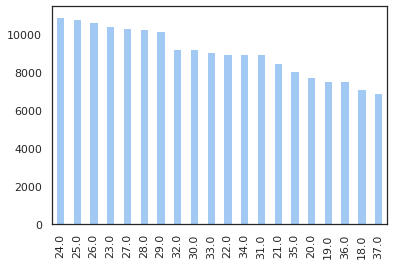

In [ ]:
# Ratings de 0 a 10
Users_Age=df_users["Age"].value_counts(ascending=False)
Users_Age.head(20).plot.bar()
Users_Age.head(20)



[(0.0, 0.035), (1.0, 100.0)]

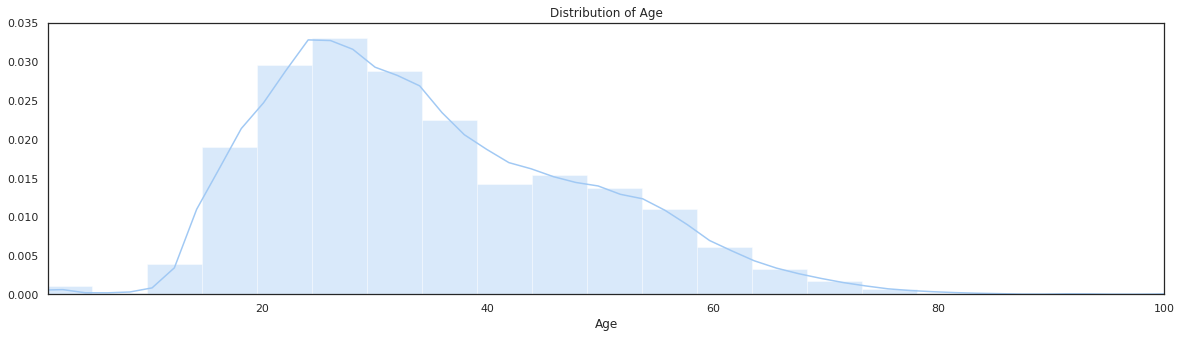

In [ ]:
#Histograma com distribuição de idade
plt.figure(figsize=(20,5))
plt.title("Distribution of Age")
ax = sns.distplot(df_users["Age"])
ax.set(xlim=(1, 100), ylim=(0, 0.035))


###2.2 Books

In [ ]:
#Verificando as estatísticas básicas
df_book.describe(exclude=[np.object])

,Year-Of-Publication
count,271379.000000
mean,1959.763394
std,257.983943
min,0.000000
25%,1989.000000
50%,1995.000000
75%,2000.000000
max,2050.000000


In [ ]:
#Entendendo se temos muitos valores faltantes
df_book.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271379 entries, 0 to 271378
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271379 non-null  object
 1   Book-Title           271379 non-null  object
 2   Book-Author          271378 non-null  object
 3   Year-Of-Publication  271379 non-null  int64 
 4   Publisher            271377 non-null  object
 5   Image-URL-S          271379 non-null  object
 6   Image-URL-M          271379 non-null  object
 7   Image-URL-L          271379 non-null  object
dtypes: int64(1), object(7)
memory usage: 16.6+ MB


2002    17628
1999    17432
2001    17360
2000    17235
1998    15767
1997    14892
2003    14359
1996    14031
1995    13548
1994    11796
1993    10603
1992     9906
1991     9389
1990     8661
1989     7937
1988     7493
1987     6529
1986     5841
2004     5839
1985     5343
Name: Year-Of-Publication, dtype: int64

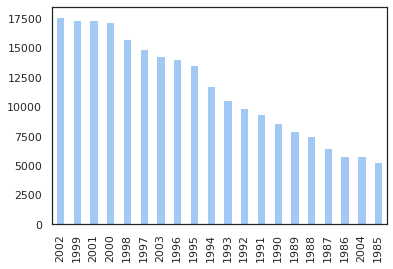

In [ ]:
# Anos de publicação Top 20
Ratings=df_book["Year-Of-Publication"].value_counts(ascending=False)
Ratings.head(20).plot.bar()
Ratings.head(20)



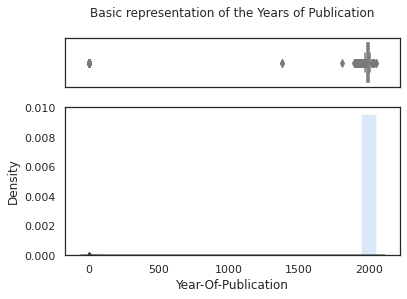

In [ ]:
#Histograma de pontos com toda base

#Subplot grid
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (0.25, 0.75)})
 
#Plot + subplot grid
sns.boxplot(df_book["Year-Of-Publication"], ax=ax_box).set_title("Basic representation of the Years of Publication\n")
sns.distplot(df_book["Year-Of-Publication"], ax=ax_hist, kde=False, fit=stats.gamma, bins=20)
sns.set_color_codes("bright")

#Legendas
ax_box.set(xlabel='') #Remove x axis name for the boxplot
ax_hist.set(ylabel='Density')

plt.show()

In [ ]:
Q3 = np.quantile(df_book["Year-Of-Publication"], 0.75) #Third quartile
Q1 = np.quantile(df_book["Year-Of-Publication"], 0.25) #First quartile
IQR = Q3 - Q1 #Inter Quartile Range
sns.set_color_codes("bright")

outlier_score_threshold =  Q3 + 1.5 * IQR
outlier_number=len(df_book[df_book["Year-Of-Publication"] > outlier_score_threshold ])

print("Number of outliers:", outlier_number,
      "\nOutlier proportion:", round(outlier_number/len(df_book_rating["Book-Rating"])*100, 3),"%",
      "\nOutlier threshold score:", outlier_score_threshold,"/ 100")

Number of outliers: 17 
Outlier proportion: 0.001 % 
Outlier threshold score: 2016.5 / 100


[(0.0, 0.05), (1940.0, 2050.0)]

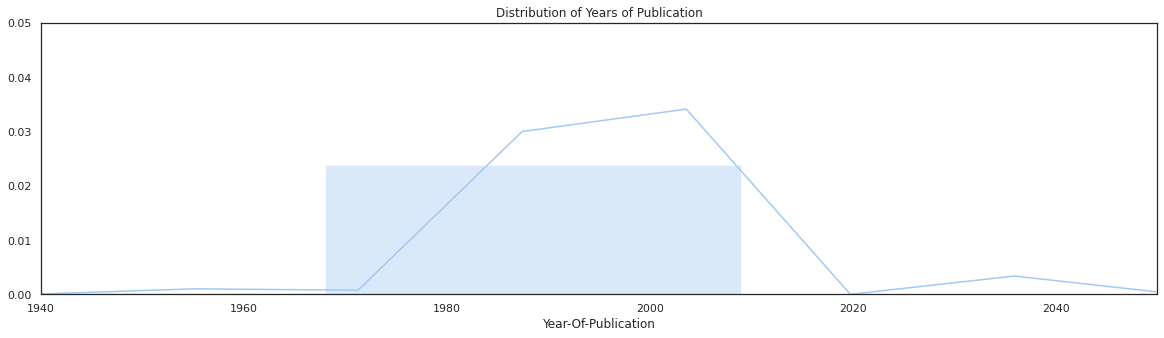

In [ ]:
#Histograma com distribuição dos anos de publicação
plt.figure(figsize=(20,5))
plt.title("Distribution of Years of Publication")
ax = sns.distplot(df_book["Year-Of-Publication"])
ax.set(xlim=(1940, 2050), ylim=(0, 0.05))


###2.3 Books Ratings

In [ ]:
#Verificando as estatísticas básicas
df_book_rating.describe(exclude=[np.object])

,User-ID,Book-Rating
count,1.149780e+06,1.149780e+06
mean,1.403864e+05,2.866950e+00
std,8.056228e+04,3.854184e+00
min,2.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00
50%,1.410100e+05,0.000000e+00
75%,2.110280e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


In [ ]:
#Entendendo se temos muitos valores faltantes
df_book_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [ ]:
total = df_book_rating.isnull().sum().sort_values(ascending = False)
percent = (df_book_rating.isnull().sum()/df_book_rating.isnull().count()*100).sort_values(ascending = False)
missing_df_book_rating  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_df_book_rating

,Total,Percent
Book-Rating,0,0.0
ISBN,0,0.0
User-ID,0,0.0


0     716109
8     103736
10     78610
7      76457
9      67541
5      50974
6      36924
4       8904
3       5996
2       2759
Name: Book-Rating, dtype: int64

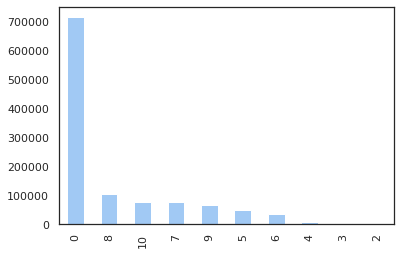

In [ ]:
# Ratings de 0 a 10
Ratings=df_book_rating["Book-Rating"].value_counts(ascending=False)
Ratings.head(10).plot.bar()
Ratings.head(10)



In [ ]:
total = df_book_rating["Book-Rating"].value_counts(ascending=False)
percent = (df_book_rating.count()/df_book_rating.count()*100).sort_values(ascending = False)
Ratings_percent  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
Ratings_percent

,Total,Percent
0,716109.0,NaN
1,1770.0,NaN
2,2759.0,NaN
3,5996.0,NaN
4,8904.0,NaN
5,50974.0,NaN
6,36924.0,NaN
7,76457.0,NaN
8,103736.0,NaN
9,67541.0,NaN


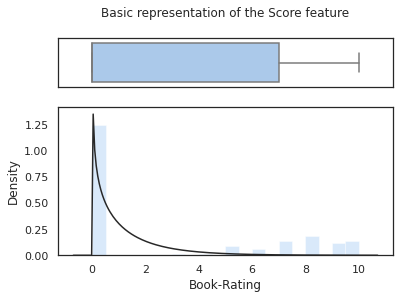

In [ ]:
#Histograma de pontos com toda base

#Subplot grid
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (0.25, 0.75)})
 
#Plot + subplot grid
sns.boxplot(df_book_rating["Book-Rating"], ax=ax_box).set_title("Basic representation of the Score feature\n")
sns.distplot(df_book_rating["Book-Rating"], ax=ax_hist, kde=False, fit=stats.gamma, bins=20)
sns.set_color_codes("bright")

#Legendas
ax_box.set(xlabel='') #Remove x axis name for the boxplot
ax_hist.set(ylabel='Density')

plt.show()

In [ ]:
Q3 = np.quantile(df_book_rating["Book-Rating"], 0.75) #Third quartile
Q1 = np.quantile(df_book_rating["Book-Rating"], 0.25) #First quartile
IQR = Q3 - Q1 #Inter Quartile Range
sns.set_color_codes("bright")

outlier_score_threshold =  Q3 + 1.5 * IQR
outlier_number=len(df_book_rating[ df_book_rating["Book-Rating"] > outlier_score_threshold ])

print("Number of outliers:", outlier_number,
      "\nOutlier proportion:", round(outlier_number/len(df_book_rating["Book-Rating"])*100, 3),"%",
      "\nOutlier threshold score:", outlier_score_threshold,"/ 100")

Number of outliers: 0 
Outlier proportion: 0.0 % 
Outlier threshold score: 17.5 / 100


[(0.0, 3.5), (-1.0, 11.0)]

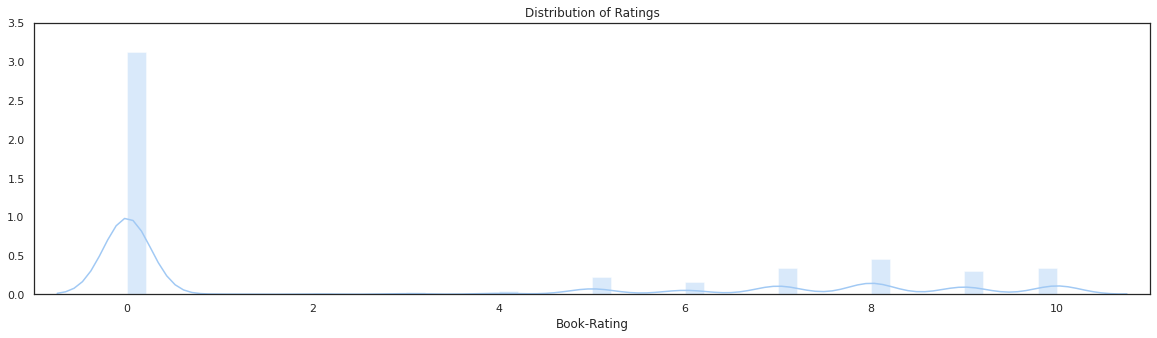

In [ ]:
#Histograma com distribuição dos Ratings
plt.figure(figsize=(20,5))
plt.title("Distribution of Ratings")
ax = sns.distplot(df_book_rating["Book-Rating"])
ax.set(xlim=(-1, 11), ylim=(0, 3.5))

# #################NORMALIZACAO DE DADOS

In [ ]:
#Normalizacao de Location para poder fazer comparacao. Removendo espacos em blanco

df_users['Location_CY'] = df_users['Location_CY'].str.strip()
df_users

,User-ID,Location_CT,Location_UF,Location_CY,Age
0,120567,545,rheinland-pfalz,germany,NaN
1,84244,01109,sachsen,germany,40.0
2,151969,1700,fribourg,switzerland,24.0
3,147786,01721,NaN,NaN,37.0
4,160922,3003,tenerife,espaã±a,30.0
...,...,...,...,...,...
537945,278855,tacoma,washington,united kingdom,50.0
537946,278856,brampton,ontario,canada,NaN
537947,278857,knoxville,tennessee,usa,NaN
537948,278858,dublin,n/a,ireland,NaN


In [ ]:
# Procurando os usuario que sao do pais usa
import numpy as np
df_users_usa = df_users[(df_users['Location_CY'] == "usa")]
df_users_usa

,User-ID,Location_CT,Location_UF,Location_CY,Age
8,266829,05680,vermont,usa,NaN
13,155407,10012,new york,usa,NaN
14,198308,10458,new york,usa,46.0
18,223378,33156,florida,usa,17.0
20,130531,39180,mississippi,usa,25.0
...,...,...,...,...,...
537934,278844,st. paul,minnesota,usa,28.0
537937,278847,brooklyn,new york,usa,NaN
537941,278851,dallas,texas,usa,33.0
537944,278854,portland,oregon,usa,NaN


In [ ]:
# Considerando so book rating com avaliacao explicita, o seja rating superior a 0
df_book_rating_no_zero = df_book_rating[(df_book_rating['Book-Rating'] > 0)]
df_book_rating_no_zero

,User-ID,ISBN,Book-Rating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
6,276736,3257224281,8
7,276737,0600570967,6
...,...,...,...
1149773,276704,0806917695,5
1149775,276704,1563526298,9
1149777,276709,0515107662,10
1149778,276721,0590442449,10


In [ ]:
# Relacionando os usuarios de usa e as avaliacaoes que fizeram

merged_user_book_rating_df = pd.merge(left=df_users_usa, right=df_book_rating_no_zero, left_on='User-ID', right_on='User-ID')
merged_user_book_rating_df

,User-ID,Location_CT,Location_UF,Location_CY,Age,ISBN,Book-Rating
0,82537,lockport,new york,usa,NaN,0670891568,9
1,99955,lockport,new york,usa,14.0,0060256672,10
2,99955,lockport,new york,usa,14.0,0061032034,10
3,99955,lockport,new york,usa,14.0,0064401480,8
4,99955,lockport,new york,usa,14.0,0140031928,6
...,...,...,...,...,...,...,...
249422,265087,catharpin,virginia,usa,NaN,0684842718,8
249423,265087,catharpin,virginia,usa,NaN,086571231X,9
249424,265087,catharpin,virginia,usa,NaN,1573920533,5
249425,265107,columbia,maryland,usa,NaN,0739317059,4


In [ ]:
# quantidade de usuarios unicos que avaliaram algum livro de forma explicita
users_who_evaluated = merged_user_book_rating_df['User-ID'].nunique()
users_who_evaluated

32206

In [ ]:
# quantidade de livros avaliados de forma explicita
books_evaluated = merged_user_book_rating_df['ISBN'].nunique()
books_evaluated

89473

###2.1 Users (com normalização)

In [ ]:
#Verificando as estatísticas básicas
df_users_usa.describe

<bound method NDFrame.describe of        User-ID Location_CT  Location_UF Location_CY   Age
8       266829       05680      vermont         usa   NaN
13      155407       10012     new york         usa   NaN
14      198308       10458     new york         usa  46.0
18      223378       33156      florida         usa  17.0
20      130531       39180  mississippi         usa  25.0
...        ...         ...          ...         ...   ...
537934  278844    st. paul    minnesota         usa  28.0
537937  278847    brooklyn     new york         usa   NaN
537941  278851      dallas        texas         usa  33.0
537944  278854    portland       oregon         usa   NaN
537947  278857   knoxville    tennessee         usa   NaN

[270975 rows x 5 columns]>

In [ ]:
#Entendendo se temos muitos valores faltantes
df_users_usa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 270975 entries, 8 to 537947
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   User-ID      270975 non-null  object 
 1   Location_CT  270794 non-null  object 
 2   Location_UF  270892 non-null  object 
 3   Location_CY  270975 non-null  object 
 4   Age          148260 non-null  float64
dtypes: float64(1), object(4)
memory usage: 12.4+ MB


In [ ]:
total = df_users_usa.isnull().sum().sort_values(ascending = False)
percent = (df_users_usa.isnull().sum()/df_users_usa.isnull().count()*100).sort_values(ascending = False)
missing_df_users_usa  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_df_users_usa

,Total,Percent
Age,122715,45.286466
Location_CT,181,0.066796
Location_UF,83,0.030630
Location_CY,0,0.000000
User-ID,0,0.000000


california       19628
 california      18896
texas             8206
 texas            7904
new york          7733
 new york         7418
florida           6877
 florida          6624
pennsylvania      5891
illinois          5745
 pennsylvania     5741
washington        5679
 illinois         5541
 washington       5504
ohio              4562
michigan          4486
 ohio             4402
 michigan         4361
oregon            4229
virginia          4215
Name: Location_UF, dtype: int64

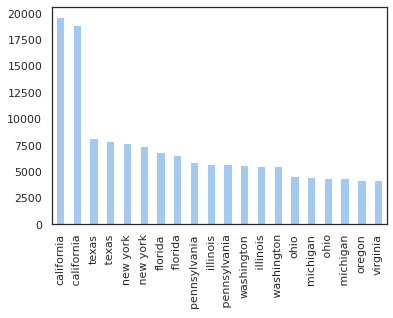

In [ ]:
# UF dos usuários
Users_USA_UF=df_users_usa["Location_UF"].value_counts(ascending=False)
Users_USA_UF.head(20).plot.bar()
Users_USA_UF.head(20)

34.0    4232
33.0    3839
35.0    3835
32.0    3733
29.0    3717
36.0    3585
24.0    3548
28.0    3540
31.0    3530
30.0    3524
26.0    3460
25.0    3435
27.0    3426
37.0    3285
38.0    3207
23.0    3191
39.0    3130
40.0    3046
41.0    3040
43.0    3009
Name: Age, dtype: int64

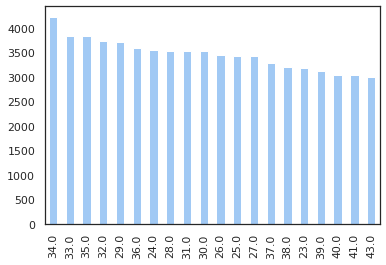

In [ ]:
# Idade dos usuários - aumentou bastante a idade média vs base full
Users_USA_Age=df_users_usa["Age"].value_counts(ascending=False)
Users_USA_Age.head(20).plot.bar()
Users_USA_Age.head(20)



In [1]:
#Histograma com distribuição de idade
plt.figure(figsize=(20,5))
plt.title("Distribution of Age")
ax = sns.distplot(df_users_usa["Age"])
ax.set(xlim=(1, 100), ylim=(0, 0.035))


NameError: ignored

## 3. Desenvolvimento Filtragem Colaborativa
Executaremos a filtragem com DL e sem DL, para depois compararmos as principais métricas:

**Qualidade de predição (acurácia)**
- Mean Absolute Error (MAE) - https://keras.io/api/metrics/regression_metrics/#meanabsoluteerror-class
- Mean Squared Error (MSE) / Loss - https://keras.io/api/metrics/regression_metrics/#meansquarederror-class
- Root Mean Square Error (RMSE) - https://keras.io/api/metrics/regression_metrics/#rootmeansquarederror-class 

**Conjunto de recomendações**
https://keras.io/api/metrics/classification_metrics/#auc-class 
Usar Fit and Score??
- Precisão (P) - proporção de recomendações consideradas boas
- Revocação (R ) - boas recomendações recuperadas pelo sistema
- F1 - média ponderada entre P e R.

**Lista de recomendação gerada**
- Half-life utility (R-Score) - mede a qualidade da lista gerada, ordenando os com maior fit no topo e vai descendo


### 3.1 - F.C. com Deep Learning

In [ ]:
#https://medium.com/@jdwittenauer/deep-learning-with-keras-recommender-systems-e7b99cb29929
import sklearn as sk
from sklearn.preprocessing import LabelEncoder

user_enc = LabelEncoder()
merged_user_book_rating_df['userUniq'] = user_enc.fit_transform(merged_user_book_rating_df['User-ID'].values)
n_users = merged_user_book_rating_df['userUniq'].nunique()

book_enc = LabelEncoder()
merged_user_book_rating_df['bookUniq'] = book_enc.fit_transform(merged_user_book_rating_df['ISBN'].values)
n_books = merged_user_book_rating_df['bookUniq'].nunique()

merged_user_book_rating_df['Book-Rating'] = merged_user_book_rating_df['Book-Rating'].values.astype(np.float32)
min_rating = min(merged_user_book_rating_df['Book-Rating'])
max_rating = max(merged_user_book_rating_df['Book-Rating'])

n_users, n_books, min_rating, max_rating

(32206, 89473, 1.0, 10.0)

In [ ]:
from sklearn.model_selection import train_test_split

X = merged_user_book_rating_df[['userUniq', 'bookUniq']].values
y = merged_user_book_rating_df['Book-Rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((224484, 2), (24943, 2), (224484,), (24943,))

In [ ]:
n_factors = 50
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [ ]:
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2
def RecommenderV1(n_users, n_books, n_factors):
    user = Input(shape=(1,))
    u = Embedding(n_users, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user)
    u = Reshape((n_factors,))(u)
    
    book = Input(shape=(1,))
    m = Embedding(n_books, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(book)
    m = Reshape((n_factors,))(m)
    
    x = Dot(axes=1)([u, m])
    model = Model(inputs=[user, book], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [ ]:
model = RecommenderV1(n_users, n_books, n_factors)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        1610300     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 50)        4473650     input_2[0][0]                    
____________________________________________________________________________________________

In [ ]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=5,
                    verbose=1, validation_data=(X_test_array, y_test))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 224484 samples, validate on 24943 samples
Epoch 1/5
224484/224484 [==============================] - 27s 121us/step - loss: 60.6334 - val_loss: 56.4157
Epoch 2/5
224484/224484 [==============================] - 25s 113us/step - loss: 44.1275 - val_loss: 41.4220
Epoch 3/5
224484/224484 [==============================] - 26s 114us/step - loss: 27.3650 - val_loss: 32.9646
Epoch 4/5
224484/224484 [==============================] - 25s 113us/step - loss: 17.7193 - val_loss: 28.2421
Epoch 5/5
224484/224484 [==============================] - 25s 113us/step - loss: 12.1369 - val_loss: 25.4947


### 3.2 - F.C. sem Deep Learning

## 4. Comparativo e análise
Verificamos as principais métricas dos dois algoritmos, comparando e identificando diferenças

## 5. Conclusão
Fechamos o trabalho com a percepção final sobre os 2 modelos executados.